## Creating Popular artists 

Music is one of the biggest industries in the world, totalling upwards of $130 billion dollars of revenue globally. With such a large following from the public, and so many new and veteran artists crowding the marketplace, how can an individual or record label create the most profit using data we already have? In this project, I attepmt to tease out bits and pieces of information that would impact an artists standing in terms of popularity, which in turn, will reflect on the revenue this artist generates.  

The dataset that I am running this analysis off of is a subset of the "1 million song data set", the "10,000 song dataset". This dataset was provided by The Echo Nest, a music intelligence and data platform that was acquired by Spotify in 2014. I'll be trying to use this data to predict whether an artist will be "hot" or "not" based on the characteristics of said artist. I'll be defining an artist as "hot" if this artist is in the top 75 percent of all the artists.

To begin with, Let's install our dependecies that we need for this project. 

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

## Data Exploration

In [3]:
#import data to pandas
data = pd.read_csv('music.csv')

In [4]:
#finding all the columns in the dataset
data.columns

Index(['artist.hotttnesss', 'artist.id', 'artist.name', 'artist_mbtags',
       'artist_mbtags_count', 'bars_confidence', 'bars_start',
       'beats_confidence', 'beats_start', 'duration', 'end_of_fade_in',
       'familiarity', 'key', 'key_confidence', 'latitude', 'location',
       'longitude', 'loudness', 'mode', 'mode_confidence', 'release.id',
       'release.name', 'similar', 'song.hotttnesss', 'song.id',
       'start_of_fade_out', 'tatums_confidence', 'tatums_start', 'tempo',
       'terms', 'terms_freq', 'time_signature', 'time_signature_confidence',
       'title', 'year'],
      dtype='object')

Right off the bat, we see that there are a good number of variables in this dataset, 35 to be exact. We may need to run some dimensionality reduction on this set of variables later on in this project. At this point, we're not actually sure what the data actually holds, and what types of data types there are. Let's do a quick preview of the dataset and check for any missing data points that could affect our analyses.

In [5]:
data.head(5)

,artist.hotttnesss,artist.id,artist.name,artist_mbtags,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
0,0.401998,ARD7TVE1187B99BFB1,Casual,NaN,0.0,0.643,0.58521,0.834,0.58521,218.93179,...,218.932,0.779,0.28519,92.198,hip hop,1.000000,4.0,0.778,I Didn't Mean To,0
1,0.417500,ARMJAGH1187FB546F3,The Box Tops,classic pop and rock,1.0,0.007,0.71054,1.000,0.20627,148.03546,...,137.915,0.969,0.20627,121.274,blue-eyed soul,1.000000,4.0,0.384,Soul Deep,1969
2,0.343428,ARKRRTF1187B9984DA,Sonora Santanera,NaN,0.0,0.980,0.73152,0.980,0.73152,177.47546,...,172.304,0.482,0.42132,100.070,salsa,1.000000,1.0,0.000,Amor De Cabaret,0
3,0.454231,AR7G5I41187FB4CE6C,Adam Ant,uk,1.0,0.017,1.30621,0.809,0.81002,233.40363,...,217.124,0.601,0.56254,119.293,pop rock,0.988584,4.0,0.000,Something Girls,1982
4,0.401724,ARXR32B1187FB57099,Gob,NaN,0.0,0.175,1.06368,0.883,0.13576,209.60608,...,198.699,1.000,0.13576,129.738,pop punk,0.887288,4.0,0.562,Face the Ashes,2007


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
artist.hotttnesss            10000 non-null float64
artist.id                    10000 non-null object
artist.name                  10000 non-null object
artist_mbtags                3711 non-null object
artist_mbtags_count          10000 non-null float64
bars_confidence              10000 non-null float64
bars_start                   10000 non-null float64
beats_confidence             10000 non-null float64
beats_start                  10000 non-null float64
duration                     10000 non-null float64
end_of_fade_in               10000 non-null float64
familiarity                  9996 non-null float64
key                          10000 non-null float64
key_confidence               10000 non-null float64
latitude                     10000 non-null float64
location                     10000 non-null object
longitude                    10000 non-null float64
loudness      

In [75]:
len(data['artist.id'].unique())

3888

Looks like there are a number of missing variables missing accross a couple of variables. Most notably, in the song.hotttnesss and artist_mbtags variables. These variables represent how popular the song is on a scale of 0 to 1, and the genre of music or "tags" that they fall into. Because the number of artist tags are provided by a third party website, there are a large number of missing values. The values from artist_mb tags may be useful, but it's just too few for us to use without any reliable imputation method, so we will drop this entire column. Song.hotttnesss on the other hand is a numerical value that ranges from 0 to 1, let's see how we can impute values for this variable. First, let's find the distributions of the variables in this dataset to get a better idea of what to impute the missing values with


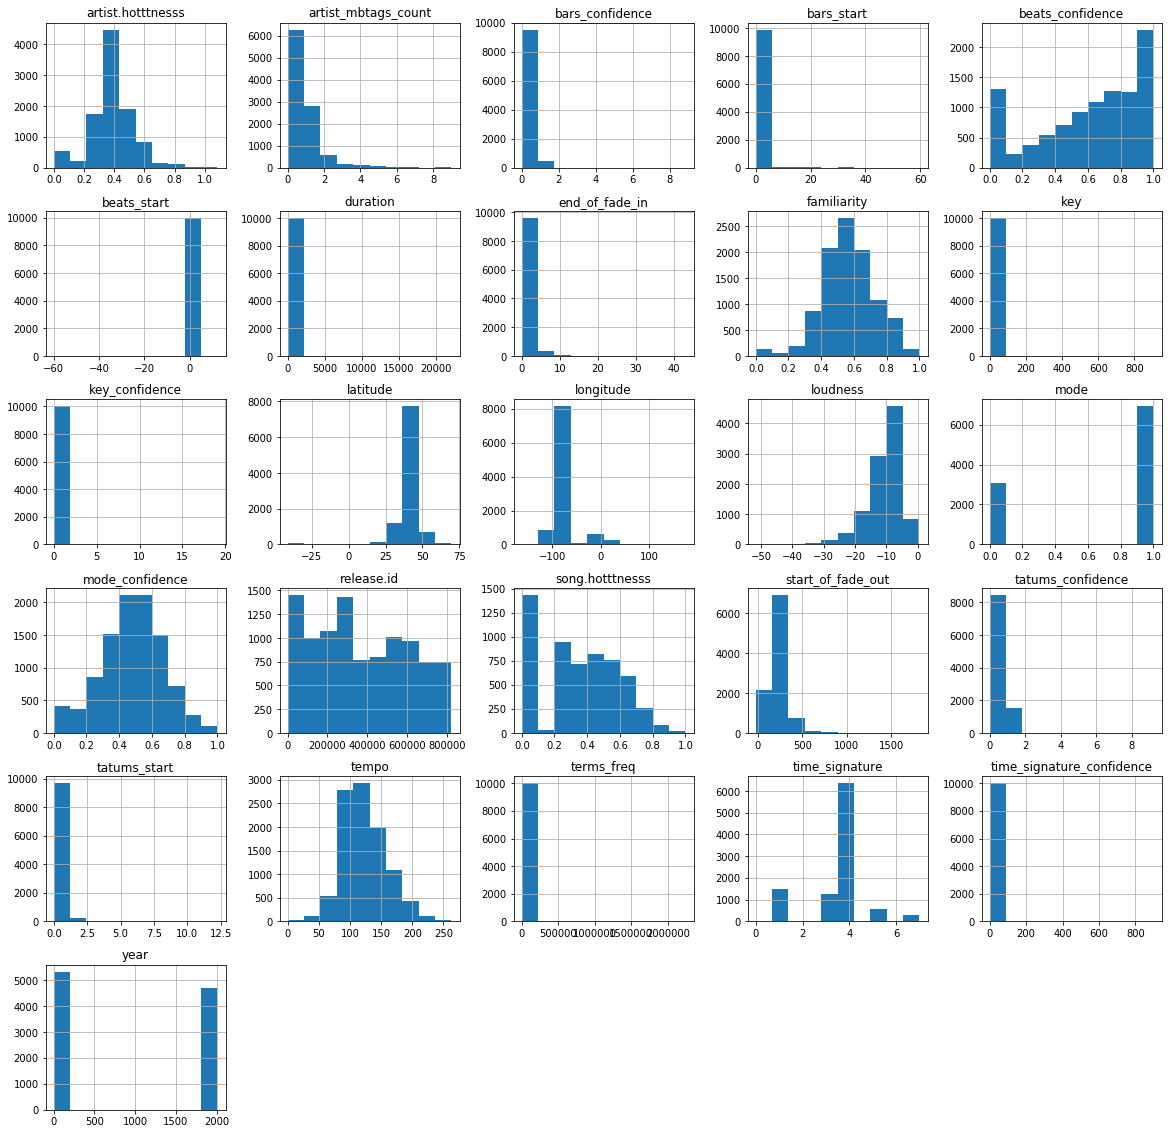

In [7]:
data.hist(figsize = (20,20))
plt.show()

At a glance, we can see that there is a large number of ratings of 0 for song.hotttnesss. This skews the distribution and makes me hesitate to impute the values with the mean, instead i'll replace the missing values for song.hotttnesss with its median value. 

Apart from song.hotttnesss, we also see that there are potential issues with the year variable where it looks like there are more songs written in the year 0 than there were in the 20th and 21st century put together. This doesn't seem right to me, so let's do a little bit of a dive into this variable too. It also looks like there are either a couple of outliers or just a bunch of 0 values for time_signature_confidence, terms_freq, tantums_start, key_confidence and a couple of other varaibles too. 

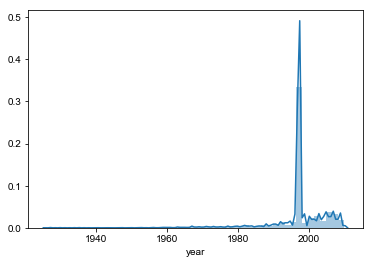

In [8]:
#dropping variables that carry information we don't care about
dta =data.drop(['artist_mbtags','artist.id','artist.name','location','title','song.id','release.name','release.id'] , axis = 1)
#imputing the median value into missing values for song.hotttnesss and dropping the remaining missing values.
dta['song.hotttnesss'] = dta['song.hotttnesss'].fillna(dta['song.hotttnesss'].median())
dta = dta.dropna()

#replacing 0 in year with the mean and replotting the distribution
avg_year = dta.year[dta.year != 0]
dta.year[dta.year==0] = avg_year.mean()
sns.distplot(dta.year)
sns.set_style('darkgrid')
plt.show()

Text(0.5,0,'bars start time')

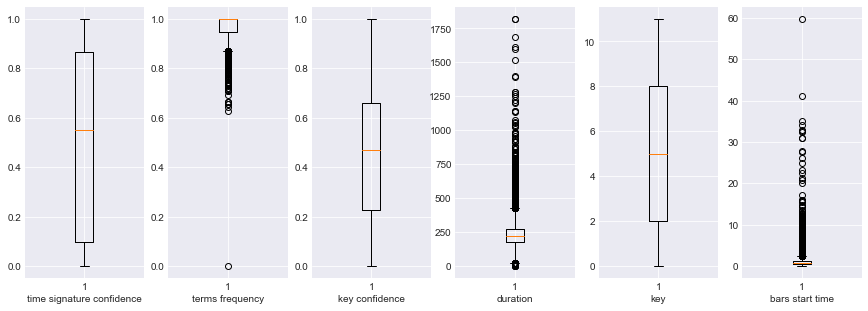

In [9]:
#looking into the other variables with potential issues
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize = (15,5))
ax1.boxplot(dta.time_signature_confidence)
ax1.set_xlabel("time signature confidence")

ax2.boxplot(dta.terms_freq)
ax2.set_xlabel('terms frequency')

ax3.boxplot(dta.key_confidence)
ax3.set_xlabel('key confidence')

ax4.boxplot(dta.duration)
ax4.set_xlabel('duration')

ax5.boxplot(dta.key)
ax5.set_xlabel('key')

ax6.boxplot(dta.bars_start)
ax6.set_xlabel('bars start time')

So it looks like there may be some outliers with duration, bars start time and terms frequency. This will be dealt with later. Let's first take a look at how we define "Hot artists", since it'll be our variable of interest. As mentioned above, we'll be measuring an artists popularity through quantiles. Artists that are in the 75th percentile are considered "popular" for the purposes of this analysis.

Even though we've seen the distribution of artist hotnesss in the compilation of plots above, let's take a deeper look into what this variable has to offer. 

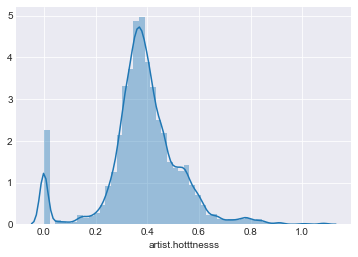

In [10]:
sns.distplot(dta['artist.hotttnesss'])
plt.show()

In [11]:
_75th = np.percentile(dta['artist.hotttnesss'],75)
dta['artist_popular'] = np.where(dta['artist.hotttnesss']>_75th,1,0)
print("artists are considered popular if they have a 'hotnesss' value of over:" , _75th)

artists are considered popular if they have a 'hotnesss' value of over: 0.45413863225000006


count    9990.000000
mean        0.250050
std         0.433063
min         0.000000
25%         0.000000
50%         0.000000
75%         0.750000
max         1.000000
Name: artist_popular, dtype: float64


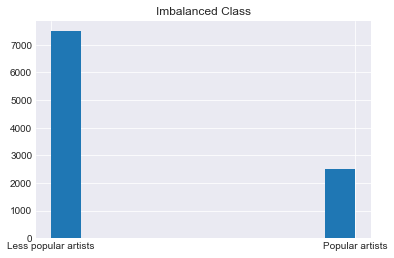

In [74]:

X = dta.drop(['artist.hotttnesss','artist_popular'], 1)
Y_class = dta['artist_popular']

print(Y_class.describe())
plt.hist(Y_class)
plt.title('Imbalanced Class')
plt.xticks(np.arange(2), ('Less popular artists', 'Popular artists'))
plt.show()


Looks like there is a little bit a class imbalance in this dataset, let's over sample the "hot" artists. we will revisit this in a bit when we create our training and test datasets


## Feature Selection

Now that we've figured out our target variable, let's move on to finding features for our model. More specifically, let's find ways to reduce our number of features down to the most important ones. 

In [13]:
print("currently we have:", len(X.columns), "variables")

currently we have: 26 variables


In [14]:
#Let's try tease out some correlations between our features and how hot the artist is
dta.corr()['artist.hotttnesss'].abs().sort_values(ascending = False)

artist.hotttnesss            1.000000
familiarity                  0.811235
artist_popular               0.679878
artist_mbtags_count          0.482668
song.hotttnesss              0.340453
loudness                     0.189682
terms_freq                   0.073208
tempo                        0.050939
time_signature               0.043765
year                         0.036214
time_signature_confidence    0.032846
bars_confidence              0.032059
beats_confidence             0.031300
key                          0.022918
duration                     0.021076
start_of_fade_out            0.020652
mode                         0.018992
tatums_start                 0.011179
key_confidence               0.009978
beats_start                  0.009918
bars_start                   0.008717
longitude                    0.008071
tatums_confidence            0.007959
end_of_fade_in               0.001448
mode_confidence              0.000976
latitude                     0.000153
Name: artist

Having a list of all the correlation coefficients between our features and the target variable is useful to see what sort of variables will affect the model the most, and in some cases, like this one, prevent certain catastrophic mistakes. From our list of correlation values, one variable that stands out the most to me is the familiarity. Familiarity has a correlation coefficient of 0.811 with our target variable. This means that it's very similar to artist.hotttnesss and having familiarity as a feature to predict artist hotness could lead to potential data leaking, and our models being unrealistically accurate. So just in case of that, i'll be dropping that variable from the list of features, along with two other string variables that do not bring any additional information to our model. 

In [81]:
#dropping more meaningless variables. 
# dropped familiarity to prevent data leaking explain -- 
X = X.drop(['terms', 'similar','familiarity'], axis = 1)

We've got a list of variables that are most correlated with our target variable "aritst.hotttnesss", now let's see if there are any intercorrelated variables within our set of features. 

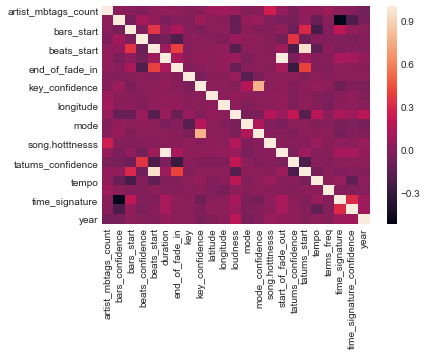

In [82]:
corr_matrix = X.corr()
sns.heatmap(corr_matrix)

In [96]:
hello = corr_matrix.abs().unstack().sort_values()
hello[(hello > 0.5) & (hello !=1)]

time_signature     bars_confidence      0.520587
bars_confidence    time_signature       0.520587
key_confidence     mode_confidence      0.772551
mode_confidence    key_confidence       0.772551
beats_start        tatums_start         0.953021
tatums_start       beats_start          0.953021
duration           start_of_fade_out    0.998424
start_of_fade_out  duration             0.998424
dtype: float64

We have some highly correlated features, Let's remove them through PCA.

In [108]:
dta_numerical = dta._get_numeric_data().drop(['artist.hotttnesss','artist_popular'],1)
scaled_dta = preprocessing.StandardScaler().fit_transform(dta_numerical)
pca = PCA(n_components = 18)
y_pca = pca.fit(scaled_dta)
print(y_pca.explained_variance_ratio_)
print("Variance Explained by components: ",sum(y_pca.explained_variance_ratio_))
#after pca combine string variables back

[0.11334226 0.09443767 0.07905083 0.07438725 0.06543091 0.05492561
 0.04941869 0.0459282  0.04471137 0.04301174 0.0410787  0.03930196
 0.03503704 0.03385899 0.03040964 0.02973752 0.0280538  0.02714877]
Variance Explained by components:  0.9292709336789012


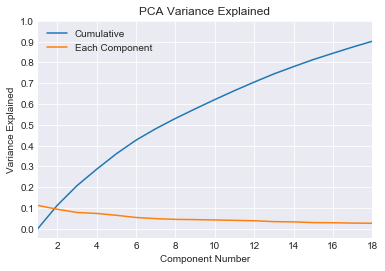

In [98]:
variance_sums = []
for i in range(18):
    variance_sums.append(sum(pca.explained_variance_ratio_[:i]))

plt.plot(range(1, 19), variance_sums[:], label='Cumulative')
plt.plot(range(1,19), pca.explained_variance_ratio_[:18], 
         label='Each Component')
plt.title('PCA Variance Explained')
plt.xlim([1, 18])
plt.xlabel('Component Number')
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.ylabel('Variance Explained')
plt.legend()
plt.show()

In [99]:
dta_pca = pd.DataFrame(pca.fit_transform(scaled_dta))

In [100]:
#Creating testing and training data sets and balancing the classes

X_Train, X_Test, Y_Train, Y_Test = train_test_split(dta_pca,Y_class)
sm = SMOTE()
X_Train_os, Y_Train_os = sm.fit_sample(X_Train,Y_Train)

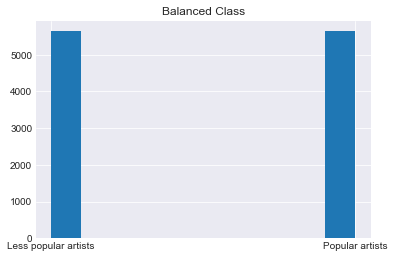

In [101]:
plt.hist(Y_Train_os)
plt.xticks(np.arange(2), ('Less popular artists', 'Popular artists'))
plt.title('Balanced Class')
plt.show()

In [102]:
print("we've got" , len(X_Train.columns), "variables")

we've got 18 variables


## Modeling and Validation

In [103]:
def confusion_matrix(x, y):
    '''
    Plots confusion matrix 
    '''
    matrix = metrics.confusion_matrix(x,y)
    ax = plt.axes()
    g = sns.heatmap(matrix, annot = True,
                   xticklabels=['True','False'], yticklabels=['True','False'],
                   fmt = 'd', ax = ax)
    ax.set_title('Confusion Matrix')
    plt.show()
    return g 

Now that we can move on to the actual classifier. For the sake of simplicity, I'll start with fitting a singular decision tree as a classifier and seeing how it does.

In [109]:
decision_tree = tree.DecisionTreeRegressor(max_depth=5)
decision_tree.fit(X_Train_os, Y_Train_os)
print(decision_tree.score(X_Train_os, Y_Train_os))
print(cross_val_score(decision_tree,X_Test,Y_Test, cv = 10))

0.6015400045457109
[0.29140449 0.37639673 0.39826118 0.31602363 0.45513122 0.41745592
 0.49834839 0.4004355  0.46894927 0.44652618]


Looks like the decision tree didn't do very well, with an accuracy score of 0.616. This model is only correct 61% of the time. On top of that, when we move on to running the model on the testing data, the scores are actually lower than 61%. The decision tree actually overfit the training data and didn't capture much information, because the decision tree performed so poorly, i dont think tuning the parameters of this model would create the needed difference in accuracy that we are looking for. This is expected though, single decision trees dont usually explain alot, but when run with a bunch of other decision trees in an ensemble model like random forrest, the predictions get alot more accurate.  Let's move on to a couple of other machine learning algorithms. Next, let's evaluate how well SVM, K nearest neighbors and random forrest models do. 

Cross Validation Scores: [0.86454183 0.844      0.868      0.888      0.908      0.888
 0.876      0.87148594 0.90763052 0.89156627]
ROC_AUC Score:  0.8667974285172726


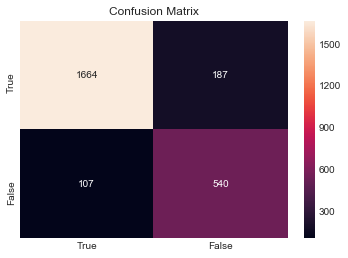

In [105]:
from sklearn.svm import SVC
from sklearn import metrics as metrics
svc = SVC()
svc.fit(X_Train_os,Y_Train_os)
y_pred = svc.predict(X_Test)
print("Cross Validation Scores:" , cross_val_score(svc, X_Test,Y_Test, cv = 10))
print("ROC_AUC Score: " , metrics.roc_auc_score(Y_Test,y_pred))
confusion_matrix(Y_Test, y_pred)

Cross Validation Scores: [0.8247012  0.792      0.868      0.852      0.864      0.876
 0.84       0.85542169 0.89156627 0.87550201]
ROC_AUC Score:  0.8135382770664923


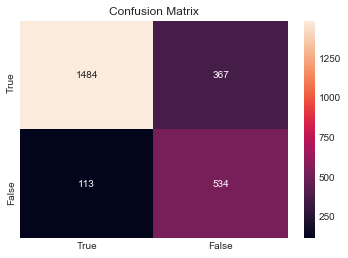

In [106]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
neighbors.fit(X_Train_os,Y_Train_os)
y_neighbors_pred = neighbors.predict(X_Test)
print("Cross Validation Scores:" ,cross_val_score(neighbors, X_Test, Y_Test, cv = 10))
print("ROC_AUC Score: " , metrics.roc_auc_score(Y_Test, y_neighbors_pred))
confusion_matrix(Y_Test, y_neighbors_pred)

Cross Validation Scores: [0.85258964 0.856      0.876      0.868      0.904      0.856
 0.888      0.86746988 0.89156627 0.87148594]
ROC_AUC Score:  0.8373864496988553


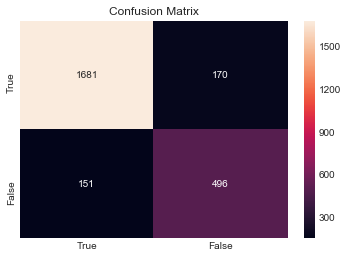

In [107]:
from sklearn import ensemble 

rfc = ensemble.RandomForestClassifier()
rfc.fit(X_Train_os,Y_Train_os)
rfc.score(X_Train_os,Y_Train_os)
y_rfc_pred = rfc.predict(X_Test)
print("Cross Validation Scores:" ,cross_val_score(rfc, X_Test, Y_Test, cv = 10, scoring = 'accuracy'))
print("ROC_AUC Score: " , metrics.roc_auc_score(Y_Test, y_rfc_pred))
confusion_matrix(Y_Test, y_rfc_pred)

Seems like the cross validation scores are roughly the same across all three of these models, so we'll look at another way to measure model performance, the confusion matrix. The confusion matrix measures the different types of errors that the model produces. It looks like the nearest neighbors model actually predicted a significant amount more false positives than the other two models, so we'll eliminate this model. 

Now that we've narrowed down the models to the SVM and Random Forrest, we'll need yet another model performance indicator. In this case, we'll be following the ROC AUC score and come to the conclusion that the support vector machine is the most suitable model for the data that we have at the moment since it has the higher ROC AUC score. 

So the Support Vector Machine model created the best possible performance for us, which means that whenever we have a new artist that we're trying to predict the success of in the future, we'll feed this new artists statistics into the SVM model and we can predict whether this artist will be popular or not correctly roughly 85 times out of 100. This will allow indivudals or record labels gauge their investment strategy and look at what needs to be changed to create a more successful artist.